# Import Dependencies

In [1]:
import os
import cv2

import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Build Data Loading Functions

In [3]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=48ad4243-5131-431c-b33b-a9fe5e52bc32
To: /home/gs/Documents/Personal_Projects/LipReader/data.zip
100%|██████████| 423M/423M [02:37<00:00, 2.69MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [4]:
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frame = frame[190:236, 80:220]  # Crop the frame
        frames.append(frame)

    cap.release()

    transform = transforms.Compose([
        transforms.ToTensor(),                     # Convert to torch tensor (H x W x C -> C x H x W)
        transforms.Grayscale(num_output_channels=1) # Convert to grayscale (C x H x W -> C=1 x H x W)
    ])

    frames = [transform(frame) for frame in frames]
    frames = torch.stack(frames, dim=0)
    frames = frames.permute(0, 2, 3, 1)

    mean = frames.mean()
    std = frames.std()
    return (frames - mean) / std


In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

# Mapping characters to integers
char_to_num = {char: num for num, char in enumerate(vocab)}
# Mapping integers back to original characters
num_to_char = {num: char for char, num in char_to_num.items()}

print(f"The vocabulary is: {vocab} (size = {len(vocab)})")


The vocabulary is: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 39)


In [6]:
def load_alignments(path: str) -> List[int]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([char_to_num[char] for char in ' ' + line[2]])
    return torch.tensor(tokens[1:])  # Skip the first element, which is a space ' '


In [7]:
def load_data(path: str): 
    #path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [8]:
def mappable_function(path: str) -> List[torch.Tensor]:
    frames, alignments = load_data(path)
    return [frames.to(torch.float32), alignments.to(torch.int64)]


# 2. Create Data Pipeline

In [9]:
# Assume mappable_function returns a list of PyTorch tensors [frames, alignments]
# Make sure to replace it with the correct implementation of the mappable_function.

class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.file_paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        return mappable_function(file_path)

data_dir = './data/s1'
dataset = MyDataset(data_dir)

# The following lines are equivalent to tf.data.Dataset.shuffle(500, reshuffle_each_iteration=False)
shuffle_indices = torch.randperm(len(dataset))
dataset = torch.utils.data.Subset(dataset, shuffle_indices)

# The following line is equivalent to tf.data.Dataset.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
def collate_fn(batch):
    frames, alignments = zip(*batch)
    max_seq_length_frames = max(frame.shape[1] for frame in frames)
    max_seq_length_alignments = max(align.shape[0] for align in alignments)

    padded_frames = [torch.nn.functional.pad(frame, (0, max_seq_length_frames - frame.shape[1])) for frame in frames]
    padded_alignments = [torch.nn.functional.pad(align, (0, max_seq_length_alignments - align.shape[0])) for align in alignments]

    return torch.stack(padded_frames), torch.stack(padded_alignments)

data_loader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

# The following line is equivalent to tf.data.Dataset.prefetch(tf.data.AUTOTUNE)
data_loader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

# Added for split
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# To use DataLoader with random_split, create separate DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)


In [10]:
# Get the first batch of data from the DataLoader
val_batch = next(iter(data_loader))

In [11]:
val_batch[1][0].numpy()

array([18,  4, 19, 38,  6, 17,  4,  4, 13, 38,  1, 24, 38,  9, 38, 19,  7,
       17,  4,  4, 38,  0,  6,  0,  8, 13])

In [12]:
decoded_string = ''.join([num_to_char[x] for x in val_batch[1][0].numpy()])
decoded_string

'set green by j three again'

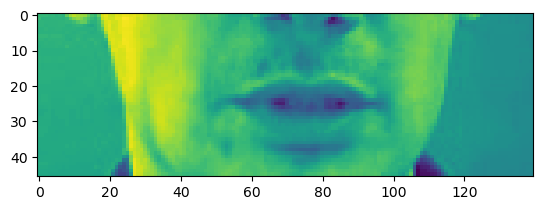

In [13]:
plt.imshow(val_batch[0][0][10])

In [ ]:
# Split the batch into frames and alignments
frames, alignments = val_batch

# Convert the frames tensor to a NumPy array and scale to the range [0, 255]
frames_numpy = (frames.numpy()).astype('uint8')

# Ensure that frames_numpy has the correct shape (batch_size, num_frames, height, width, channels)

# Save the frames of both samples in the batch as separate GIFs
for i in range(frames_numpy.shape[0]):  # Loop over the batch size
    output_file = f'./animation_sample_{i}.gif'  # Unique output file name for each sample
    fps = 10  # Set the desired frame rate (frames per second)

    # Transpose the frames to match the format expected by imageio
    frames_numpy_transposed = frames_numpy[i].transpose(0, 1, 2, 3)  # Shape: (height, width, channels, num_frames)

    # Write the GIF animation using imageio
    imageio.mimsave(output_file, frames_numpy_transposed, format='GIF', duration=100)


# 3. Design the Deep Neural Network

In [15]:
class MyModel(nn.Module):
    def __init__(self, vocab_size):
        super(MyModel, self).__init__()

        # Change the input channels of the first Conv3d layer to 1
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.conv2 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.conv3 = nn.Conv3d(in_channels=256, out_channels=75, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        # Remove the Flattening operation here

        self.lstm1 = nn.LSTM(input_size=75 * 85, hidden_size=128, bidirectional=True, batch_first=True)  # Adjusted input_size
        self.dropout1 = nn.Dropout(0.5)

        self.lstm2 = nn.LSTM(input_size=256, hidden_size=128, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)

        self.dense = nn.Linear(256, vocab_size)

    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # Flatten the tensor along dimensions 2, 3, and 4 to create a 3D tensor
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm1(x)
        x = self.dropout1(x)

        x, _ = self.lstm2(x)
        x = self.dropout2(x)

        x = self.dense(x)

        return x

In [16]:
# Create an instance of the model
model = MyModel(vocab_size=41)  # Assuming vocab_size is 41 as in your original model
model.to(device)

MyModel(
  (conv1): Conv3d(1, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(256, 75, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(6375, 128, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense): Linear(in_features=256, out_features=41, bias=True)
)

In [17]:
# Assuming you have the model and input data (val) from the previous code

# Move the input data to the GPU if available
val = next(iter(train_loader))[0].to(device)

# Set the model to evaluation mode (important for dropout and batch normalization)
model.eval()

# Perform inference
with torch.no_grad():
    yhat = model(val)

# If you need the predictions as a NumPy array, you can convert them like this:
yhat_numpy = yhat.cpu().numpy()

In [18]:
decoded_string = ''.join([num_to_char[x] for x in torch.argmax(yhat[0], dim=1).cpu().numpy()])
decoded_string

'   ppppppppa    pppppp???pp?     ppppkpppppppppppppypppppppppppppppp????ppr'

In [19]:
decoded_string = ''.join([num_to_char[x] for x in torch.argmax(yhat[1], dim=1).cpu().numpy()])
decoded_string

'cc    rrrrkk?  ppyycrraaaa      aapp kppppp??kppp?yyyr    kkk??????k?????rr'

# 4. Setup Training Options and Train

In [20]:
def ctc_loss(y_true, y_pred):
    batch_size = y_pred.size(0)
    input_length = torch.full((batch_size,), y_pred.size(1), dtype=torch.int)
    label_length = torch.full((batch_size,), y_true.size(1), dtype=torch.int)

    loss = F.ctc_loss(y_pred, y_true, input_length, label_length)
    return loss


In [21]:
import torch

class ProduceExampleCallback:
    def __init__(self, dataloader, num_to_char_fn) -> None:
        self.dataloader = dataloader
        self.num_to_char_fn = num_to_char_fn

    def produce_examples(self, model, device):
        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for batch_data, batch_labels in self.dataloader:
                batch_data = batch_data.to(device)
                yhat = model(batch_data)
                decoded = yhat.argmax(dim=2).transpose(0, 1)  # Convert to character indices

                for x in range(len(decoded)):
                    input_text = self.num_to_char_fn(batch_labels[x])
                    prediction_text = self.num_to_char_fn(decoded[x])

                    print('Original:', input_text)
                    print('Prediction:', prediction_text)
                    print('~' * 100)

    def __call__(self, model, epoch):
        # During training, call this callback at the end of each epoch
        device = next(model.parameters()).device
        self.produce_examples(model, device)


In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


In [27]:
''.join([num_to_char[x] for x in batch_labels[0].cpu().numpy()])

'bin white in g one soon'

In [23]:
# Training loop with learning rate scheduler
num_epochs = 100
for epoch in range(num_epochs):
    # Training loop for one epoch
    for batch_data, batch_labels in train_loader:  # Adjust the dataloader as per your data
        optimizer.zero_grad()
        output = model(batch_data.to(device))
        print(batch_labels.size(), output.size())
        loss = ctc_loss(batch_labels, output)
        loss.backward()
        optimizer.step()

    # Step the learning rate scheduler at the end of each epoch
    scheduler.step()

    # Save model weights at the end of each epoch (optional)
    torch.save(model.state_dict(), os.path.join('models', f'checkpoint_epoch_{epoch}.pt'))


torch.Size([2, 23]) torch.Size([2, 75, 41])


RuntimeError: input_lengths must be of size batch_size

In [48]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [52]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  2/450 [..............................] - ETA: 3:03 - loss: 213.9969 


KeyboardInterrupt



# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [53]:
model.load_weights('models/checkpoint')

In [54]:
test_data = test.as_numpy_iterator()

In [56]:
sample = test_data.next()

In [57]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 973ms/step


In [58]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

In [59]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [60]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

# Test on a Video

In [61]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [62]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [63]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 720ms/step


In [64]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [65]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]